# ECG Classifier
This application takes a 12 lead ECG as input and predicts whether it is normal or abnormal. 

In [666]:
#Imports and setup code
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#Rescales values in a 12-lead ECG to a range of -1 to 1
def normalize(signal):
    maximum = max(signal[9])
    for i in range(12):
        for j in range(len(signal[0])):
            signal[i][j] /= maximum
            
    return signal[:, :4096]

#Transforms a signal from its stored format to the format required for the model
def transform_for_input(signal):
    signal = normalize(signal)
    signal = np.swapaxes(signal, 0, 1)
    
    return np.array([signal])


## Make Predictions


In [669]:
ecg_path = f'../data/records/A00004.h5' #Modify this value to select the desired ECG
model_path = '../logs/backup_model_best.keras'

with h5py.File(ecg_path, 'r') as f:
    signal = f['ecg'][:, :4096]
    
signal = transform_for_input(signal)

model = tf.keras.models.load_model(model_path)
model.predict(signal).squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


array(0.82276803, dtype=float32)

## Training Data

### Data Exploration
The file 'metadata.csv' contains information about the patient and diagnoses associated with each ECG. Each code represents a different diagnostic statement; <b>a code of 1 signifies a normal ECG</b>.

In [671]:
df_metadata = pd.read_csv("../data/metadata.csv")
df_metadata.head(10)

,ECG_ID,AHA_Code,Patient_ID,Age,Sex,N,Date
0,A00001,22;23,S00001,55,M,5000,2020-03-04
1,A00002,1,S00002,32,M,6000,2019-09-03
2,A00003,1,S00003,63,M,6500,2020-07-16
3,A00004,23,S00004,31,M,5000,2020-07-14
4,A00005,146,S00005,47,M,5500,2020-01-07
5,A00006,1,S00006,46,F,5000,2019-08-31
6,A00007,106,S00007,75,M,6500,2020-04-01
7,A00008,1,S00008,32,M,5000,2019-10-02
8,A00009,1,S00009,48,F,6000,2019-08-20
9,A00010,1,S00010,32,F,7500,2020-06-29


First, let's take a look at the distribution of classes within the dataset. It is quite balanced, with slightly more normal than abnormal ECGs. The group of abnormal ECGs is comprised of a wide variety of different diagnoses. The code below displays the counts of normal vs abnormal records.

In [674]:
def get_class_dist(df):
    normal_cnt = len(df[df.AHA_Code == '1'])
    abnormal_cnt = len(df) - normal_cnt

    return normal_cnt, abnormal_cnt

normal_cnt, abnormal_cnt = get_class_dist(df_metadata)
print(f'The dataset contains {normal_cnt} normal ECGs and {abnormal_cnt} abnormal ECGs.')

The dataset contains 13905 normal ECGs and 11865 abnormal ECGs.


### Splitting the Data
The following code was provided by the dataset's publishers Hui et. al., and was used to split the dataset into training and test sets. Since there are a number of patients with multiple ECGs in the dataset, all records with duplicated patient IDs are placed into the test set.

In [677]:
# 80%-20% split
def ecg_train_test_split(df):
    # put all records belonging to patients with
    # multiple records in the test set
    test1 = df.Patient_ID.duplicated(keep=False)
    N = int(len(df)*0.2) - sum(test1)
    # 73 is chosen such that all primary statements exist in both sets
    df_test = pd.concat([df[test1], df[~test1].sample(N, random_state=73)])
    df_train = df.iloc[df.index.difference(df_test.index)]
    return df_train, df_test

df_train, df_test = ecg_train_test_split(df_metadata)
print(f'The training set has {len(df_train)} records')
print(f'The test set has {len(df_test)} records')

The training set has 20616 records
The test set has 5154 records


In [679]:
norm_train, abnorm_train = get_class_dist(df_train)
norm_test, abnorm_test = get_class_dist(df_test)

print(f'The training set contains {norm_train} normal ECGs and {abnorm_train} abnormal ECGs.')
print(f'The training set contains {norm_test} normal ECGs and {abnorm_test} abnormal ECGs.')

The training set contains 11295 normal ECGs and 9321 abnormal ECGs.
The training set contains 2610 normal ECGs and 2544 abnormal ECGs.


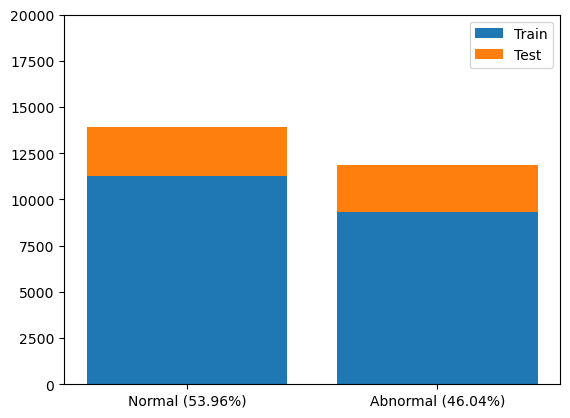

In [681]:
normal_pct = (normal_cnt / len(df_metadata)) * 100
abnormal_pct = (abnormal_cnt / len(df_metadata)) * 100

classes = [f'Normal ({normal_pct:.2f}%)', f'Abnormal ({abnormal_pct:.2f}%)']
train_cnts = [norm_train, abnorm_train]
test_cnts = [norm_test, abnorm_test]

plt.bar(classes, train_cnts)
plt.bar(classes, test_cnts, bottom=train_cnts)
plt.legend(['Train', 'Test'])
plt.ylim(0, 20000)
plt.show()

### Visualizing an ECG Record
The actual ECG tracings are each stored separate in HDF5 files, with names corresponding to the ECG ID e.g. A00001.h5

In [684]:
n = 10
print(f'The {n}-th record is ../data/records/A{n:05d}.h5')

The 10-th record is ../data/records/A00010.h5


Each file contains tracings from all 12 leads, which are accessed using the key 'ecg'.
Readings all have a sampling rate of 500hz, and range in length from 10 to 60 seconds (5000 to 30000 samples). When training the model, the first 4096 samples (slightly less than 10 seconds) of each ECG were used. The code below displays the tracings of all 12 leads overlayed on each other.

The size of record: (12, 4096)


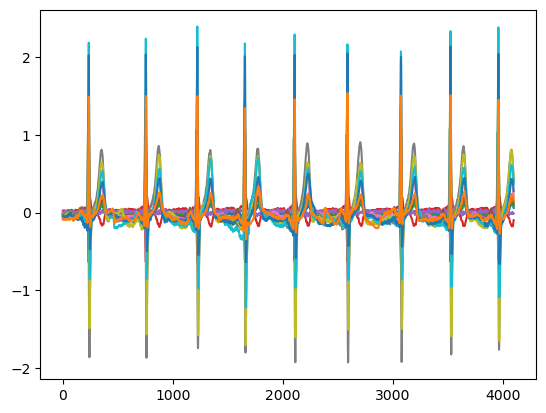

In [687]:
# read an ECG signal
n = 4
with h5py.File(f'../data/records/A{n:05d}.h5', 'r') as f:
    signal = f['ecg'][:, :4096]
    
print('The size of record: {}'.format(signal.shape))
# plot the signal
for i in range(12):
    plt.plot(signal[i])

Before being input to the model, each signal is rescaled such that the highest positive magnitude is at 1.

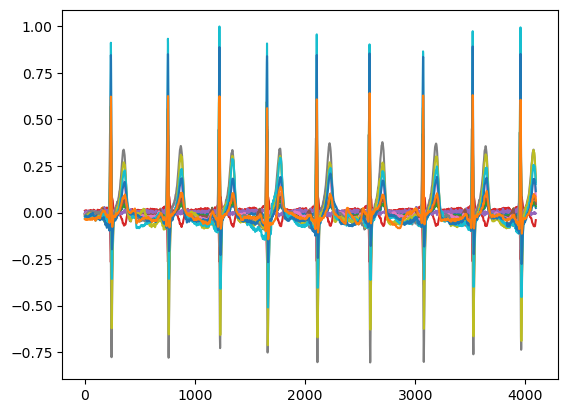

In [690]:
signal = normalize(signal)
for i in range(12):
    plt.plot(signal[i,:])

## Model Evaluation

In [693]:
from sklearn import metrics

#The raw predictions of the model over the test set before the threshold is applied
df_predictions = pd.read_csv('../eval/test_predictions.csv')
y_true = df_predictions.true_label
y_pred = df_predictions.model_output

### Threshold Selection
In this case, <b>a positive result represents a normal ECG</b>. The threshold was chosen to minimize the chance of false positives (predicting that an ECG is normal when an arrhythmia is actually present). This is more costly as it could cause a condition to go undiagnosed, while a false negative (reporting an abnormality that isn't there) can be easily resolved by the consensus of doctors reviewing the ECG.

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      2544
           1       0.89      0.73      0.80      2610

    accuracy                           0.82      5154
   macro avg       0.83      0.82      0.82      5154
weighted avg       0.83      0.82      0.82      5154



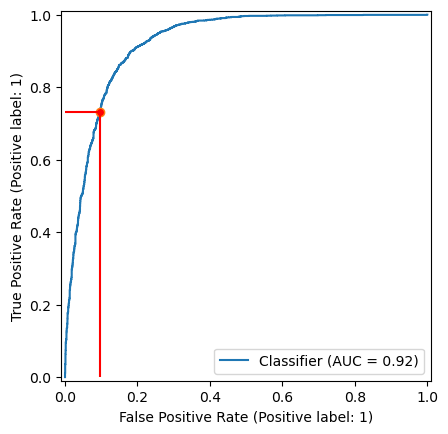

In [697]:
THRESHOLD = .8 #CHANGE THE THRESHOLD TO SEE HOW IT AFFECTS PRECISION, RECALL, AND ACCURACY

def apply_threshold(x):
    return 1 if x >= THRESHOLD else 0
y_pred_threshold = [apply_threshold(x) for x in y_pred]
print(metrics.classification_report(y_true, y_pred_threshold))


fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
thresh_idx = 0
while thresholds[thresh_idx] > THRESHOLD:
    thresh_idx += 1
        
#Display ROC Curve with selected threshold identified        
metrics.RocCurveDisplay.from_predictions(y_true, y_pred)
ax1 = plt.subplot()
ax1.plot(fpr[thresh_idx], tpr[thresh_idx], marker="o", markerfacecolor="red")
ax1.vlines(fpr[thresh_idx], 0, tpr[thresh_idx], color='red')
ax1.hlines(tpr[thresh_idx], 0, fpr[thresh_idx], color='red')
plt.show()

### Confusion Matrix
The confusion matrix shows the number of test cases for each combination of predicted and true labels. As expected with the chosen threshold of 0.8, the majority of abnormal ECGs are identified correctly by the model. A larger number of normal ECGs are incorrectly predicted to be abnormal, but as discussed previously this type of error is less likely to go unnoticed and negatively impact patients.

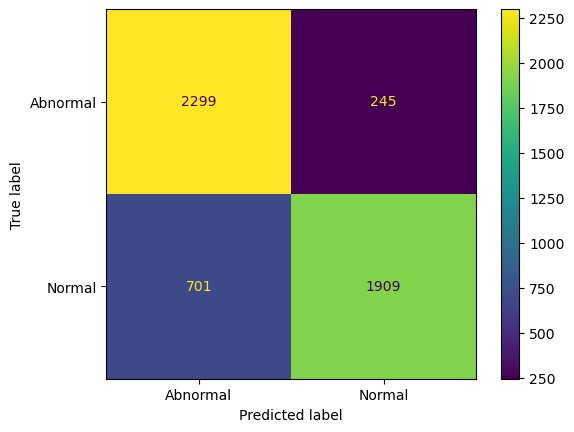

In [644]:
metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred_threshold, display_labels=['Abnormal', 'Normal'])
plt.show()